# Cell annotations with cell2sentence

### **Please note this notebook was inspired from cell2sentence's [tutorial 0](https://github.com/vandijklab/cell2sentence/blob/master/tutorials/c2s_tutorial_0_data_preparation.ipynb) and [tutorial 6](https://github.com/vandijklab/cell2sentence/blob/master/tutorials/c2s_tutorial_6_cell_annotation_with_foundation_model.ipynb) on how to preprocess and predict cell types.**

In this tutorial, we will guide you through the process of preparing and preprocessing a single-cell RNA sequencing dataset for use with C2S. 

Please note:
1. **This notebook assumes you are starting from a single-cell dataset with raw transcript counts**. You can follow these steps to preprocess your dataset for use with C2S.
2. **If you are starting from pre-normalized data**, keep in mind that C2S normalization consists of the standard filtering & count normalization steps outlined by Scanpy, with the exception that the log1p transformation is applied with base 10.
3. We use **scverse 's Rapids-singlecell** for high computational efficiency. For more information, check out [scverse](https://scverse.org/) and the [NVIDIA blog](https://developer.nvidia.com/blog/gpu-accelerated-single-cell-rna-analysis-with-rapids-singlecell/#:~:text=Scanpy%20already%20includes%20support%20for%20computing%20UMAP%20and,Scanpy%20uses%20SciPy%20and%20Numpy%20for%20scientific%20computing). Please see [here](https://rapids-singlecell.readthedocs.io/en/latest/index.html) for installations or follow the steps below:

```
pip install rapids-singlecell

pip install \
    --extra-index-url=https://pypi.nvidia.com \
    "cudf-cu11==25.4.*" "dask-cudf-cu11==25.4.*" "cuml-cu11==25.4.*" \
    "cugraph-cu11==25.4.*" "nx-cugraph-cu11==25.4.*" "cuspatial-cu11==25.4.*" \
    "cuproj-cu11==25.4.*" "cuxfilter-cu11==25.4.*" "cucim-cu11==25.4.*" \
    "pylibraft-cu11==25.4.*" "raft-dask-cu11==25.4.*" "cuvs-cu11==25.4.*" \
    "nx-cugraph-cu11==25.4.*"
```

This notebook will:
1. Load an Crohns disease single-cell dataset from Domínguez Conde et al.
Citation: Wiendl, M., Dedden, M., Liu, LJ. et al. Etrolizumab-s fails to control E-Cadherin-dependent co-stimulation of highly activated cytotoxic T cells. Nat Commun 15, 1043 (2024). [Link to paper](https://www.nature.com/articles/s41467-024-45352-6). [Link to GEO submission](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM7994747).
2. Perform preprocessing using Rapids-singlecell. Please note that not all SCANPY operations are supported by Rapids-singlecell. Hence, we may move the anndata b/w GPU and CPU.
3. Perform pathway and GO enrichment analsysis
4. Load a C2S model (C2S-Pythia-410M cell type prediction foundation model) which was pretrained to do cell type annotation on many datasets
5. Annotate the single-cell dataset using the C2S model
6. Save the enrichment analysis and predicted cell types in an excel sheet, which can be directly uploaded to T2KG and AA4P

#### Import standard libraries

In [ ]:
# Python built-in libraries
import random

import rapids_singlecell as rsc

# Third-party libraries
from pygeneconverter import ensembl_to_hugo
import pandas as pd
import gseapy as gp
import numpy as np

# Single-cell libraries
import anndata
import scanpy as sc

# Cell2Sentence imports
import cell2sentence as cs
from cell2sentence.tasks import predict_cell_types_of_data

#### Start with a random seed

In [12]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

## Load your data

In [11]:
# Load the raw counts CSV
df = pd.read_csv("/data/GSM7994747_CD/GSM7994747_CD.csv.gz", index_col=0)  # Genes in rows, cells in columns
df.head()

,AAACCCAAGCATGGGT_SAN,AAACCCAAGTAGACAT_SAN,AAACCCAAGTCCCAGC_SAN,AAACCCAAGTGAGTTA_SAN,AAACCCACACTTGGCG_SAN,AAACCCAGTATGGGAC_SAN,AAACCCAGTTACCGTA_SAN,AAACCCATCGAGTCTA_SAN,AAACCCATCGTTAGAC_SAN,AAACGAAAGGGTTGCA_SAN,...,TTTGGTTAGATGAACT_SAN,TTTGGTTCAAGGTCAG_SAN,TTTGGTTCACAGTGAG_SAN,TTTGGTTCAGATTAAG_SAN,TTTGGTTCAGCTTCGG_SAN,TTTGGTTGTAGAGGAA_SAN,TTTGGTTGTTTGGAAA_SAN,TTTGTTGAGCGTGAGT_SAN,TTTGTTGGTAACACGG_SAN,TTTGTTGGTTATGTCG_SAN
ENSG00000243485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000237613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000186092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000238009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000239945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Convert ENSEMBL IDs to HUGO nomenclature

In [13]:
# Convert from ENSEMBL to HUGO
ensembl_df = ensembl_to_hugo(df.index.tolist())
# Select only protein coding genes (or choose another filter)
ensembl_df_protein_coding = ensembl_df[ensembl_df["GENE_TYPE"]=="protein_coding"]
ensembl_df_protein_coding.head()

,ENSEMBL_ID,GENE_TYPE,HGNC_ID
2,ENSG00000186092,protein_coding,OR4F5
20,ENSG00000187634,protein_coding,SAMD11
21,ENSG00000188976,protein_coding,NOC2L
22,ENSG00000187961,protein_coding,KLHL17
23,ENSG00000187583,protein_coding,PLEKHN1


## Replace ENSEMBL IDs by HUGO symbols in the data

In [14]:
# Ensure mapper_df has old and new IDs
mapping = dict(zip(ensembl_df_protein_coding['ENSEMBL_ID'], ensembl_df_protein_coding['HGNC_ID']))

# Filter only rows where index exists in mapping
df_filtered = df[df.index.isin(mapping.keys())]

# Replace index using the mapping
df_filtered.index = df_filtered.index.map(mapping)
df_filtered.head()

,AAACCCAAGCATGGGT_SAN,AAACCCAAGTAGACAT_SAN,AAACCCAAGTCCCAGC_SAN,AAACCCAAGTGAGTTA_SAN,AAACCCACACTTGGCG_SAN,AAACCCAGTATGGGAC_SAN,AAACCCAGTTACCGTA_SAN,AAACCCATCGAGTCTA_SAN,AAACCCATCGTTAGAC_SAN,AAACGAAAGGGTTGCA_SAN,...,TTTGGTTAGATGAACT_SAN,TTTGGTTCAAGGTCAG_SAN,TTTGGTTCACAGTGAG_SAN,TTTGGTTCAGATTAAG_SAN,TTTGGTTCAGCTTCGG_SAN,TTTGGTTGTAGAGGAA_SAN,TTTGGTTGTTTGGAAA_SAN,TTTGTTGAGCGTGAGT_SAN,TTTGTTGGTAACACGG_SAN,TTTGTTGGTTATGTCG_SAN
OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SAMD11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOC2L,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KLHL17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PLEKHN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Transpose to match AnnData format: cells as rows, genes as columns
adata = anndata.AnnData(df_filtered.T)
adata.var_names_make_unique()
adata.var['gene_name'] = adata.var.index
adata.var.head()

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,gene_name
OR4F5,OR4F5
SAMD11,SAMD11
NOC2L,NOC2L
KLHL17,KLHL17
PLEKHN1,PLEKHN1


## Make var_names unique

In [16]:
adata.var_names = adata.var_names.str.upper()
adata.var_names_make_unique()
adata.var_names

Index(['OR4F5', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'C1ORF170', 'HES4',
       'ISG15', 'AGRN', 'RNF223',
       ...
       'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6',
       'MT-CYB', 'NBPF10-1', 'AL355149.2'],
      dtype='object', length=19121)

## Move anndata to GPU and apply basic scanpy filters

In [17]:
rsc.get.anndata_to_GPU(adata) # moves `.X` to the GPU
rsc.pp.filter_cells(adata, min_genes=200)
rsc.pp.filter_genes(adata, min_cells=3)

filtered out 5579 genes that are detected in less than 3 cells


In [18]:
# DATA_PATH = "/data/sc_data_IBD/sample.h5ad"
# adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 9639 × 13542
    obs: 'n_counts', 'n_genes'
    var: 'gene_name', 'n_counts', 'n_cells'

In [19]:
## Print OBS head
adata.obs.head()

,n_counts,n_genes
AAACCCAAGCATGGGT_SAN,3624.0,1125
AAACCCAAGTAGACAT_SAN,7453.0,1978
AAACCCAAGTCCCAGC_SAN,6372.0,1684
AAACCCAAGTGAGTTA_SAN,4374.0,1214
AAACCCACACTTGGCG_SAN,4894.0,1069


In [20]:
## Print VAR head
adata.var.head()

,gene_name,n_counts,n_cells
SAMD11,SAMD11,8.0,8
NOC2L,NOC2L,1084.0,999
KLHL17,KLHL17,90.0,89
PLEKHN1,PLEKHN1,49.0,42
C1ORF170,C1orf170,4.0,4


#### Add new observations "organism" and "cell_type"
"organism" should contain the name of the organism and,
"cell_type" should contain the known cell_type (if any; this can be useful when comparing with the predicted cell types later)

In [21]:
adata.obs['organism'] = 'Homo sapiens'
adata.obs['cell_type'] = ''
# adata.obs = adata.obs.rename(columns={'cell_anno_NovershternPanel': 'cell_type'})
adata.obs.head()


,n_counts,n_genes,organism,cell_type
AAACCCAAGCATGGGT_SAN,3624.0,1125,Homo sapiens,
AAACCCAAGTAGACAT_SAN,7453.0,1978,Homo sapiens,
AAACCCAAGTCCCAGC_SAN,6372.0,1684,Homo sapiens,
AAACCCAAGTGAGTTA_SAN,4374.0,1214,Homo sapiens,
AAACCCACACTTGGCG_SAN,4894.0,1069,Homo sapiens,


#### c2S requires only "organism" and "cell_type" obs. We can remove the others.

In [22]:
adata_obs_cols_to_keep  = adata.obs.columns.tolist()
adata_obs_cols_to_keep = ['organism', 'cell_type']

## Annotate mitochondrial gene counts for additional potential filtering steps

In [23]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
rsc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], log1p=False
)

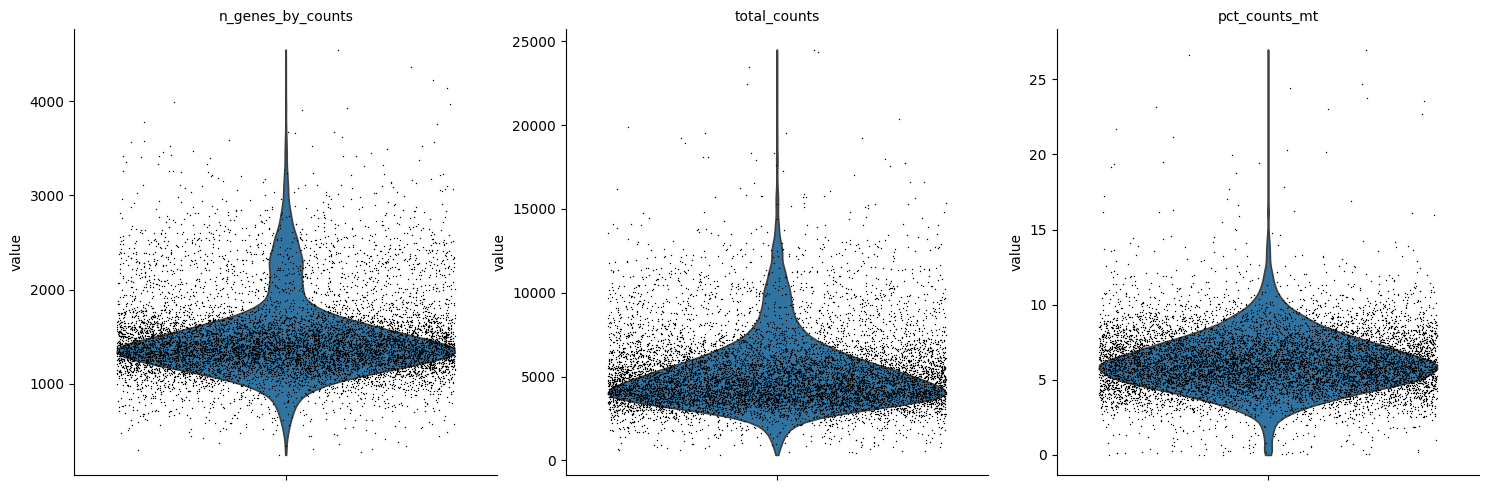

In [24]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

### Filter out cells based on quality-control metrics based on mitochondrial genes (Optional)
Check out Scanpy guidance for more information: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#quality-control

In [25]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 50, :].copy()

## Count normalization and apply additional filters

In [26]:
# Count normalization
rsc.pp.normalize_total(adata)
# moves `.X` to the CPU befre applying log transformation
rsc.get.anndata_to_CPU(adata)
# Lop1p transformation with base 10 - base 10 is important for C2S transformation!
sc.pp.log1p(adata, base=10)

## Visualization

In [27]:
# moves `.X` back to the GPU
rsc.get.anndata_to_GPU(adata)
rsc.tl.pca(adata)
rsc.pp.neighbors(adata)
rsc.tl.umap(adata)

[2025-05-13 07:40:34.671] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization


In [28]:
# Clustering
rsc.tl.leiden(adata)

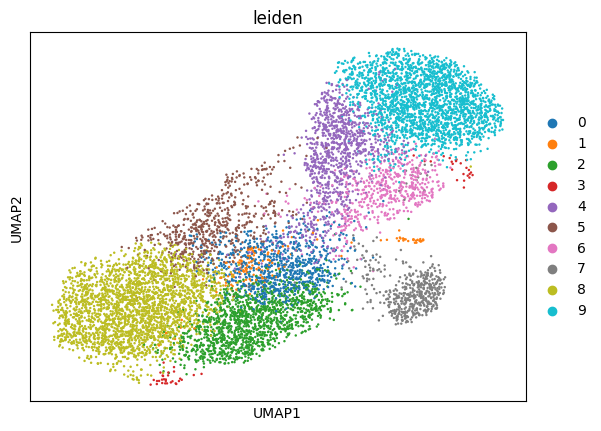

In [29]:
# Plot UMAP
sc.pl.umap(adata, color=["leiden"])

## Enrichment analysis

In [30]:
# Run differential expression (example: cluster 0 vs all, cluster 1 vs all, etc.)
rsc.tl.rank_genes_groups_logreg(adata, groupby='leiden', method='wilcoxon')

[2025-05-13 07:41:51.502] [CUML] [info] Unused keyword parameter: method during cuML estimator initialization
[2025-05-13 07:44:26.571] [CUML] [warning] L-BFGS: max iterations reached
[2025-05-13 07:44:26.572] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


#### Create a union of top 25 DE genes from each cluster

In [47]:
top_n = 25
groups = adata.uns['rank_genes_groups']['names'].dtype.names

# Store top genes per group
top_genes = set()
for group in groups:
    genes = adata.uns['rank_genes_groups']['names'][group][:top_n]
    top_genes.update(genes)

# 3. Convert to list or sorted list
top_genes_union = sorted(top_genes)  # or list(top_genes)
top_genes_union = [str(g) for g in top_genes_union]

print(f"Total unique top genes across clusters: {len(top_genes_union)}")
print(top_genes_union)

Total unique top genes across clusters: 189
['ACTG1', 'AIF1', 'ALOX5AP', 'ANKRD12', 'ANXA1', 'ANXA5', 'APBB1IP', 'ARF6', 'ARHGDIB', 'ARID4B', 'ATP5D', 'B2M', 'BTG1', 'C12ORF57', 'C12ORF75', 'C19ORF60', 'C9ORF142', 'CALM1', 'CAPZB', 'CCL5', 'CCR7', 'CD2', 'CD3E', 'CD52', 'CD74', 'CD8A', 'CD8B', 'CD96', 'CEBPD', 'CHCHD10', 'CKLF', 'CMC1', 'COA4', 'CORO1B', 'COX4I1', 'CRIP1', 'CST7', 'CTSW', 'CX3CR1', 'DDX5', 'DSTN', 'DUSP1', 'EEF1A1', 'EEF1G', 'EEF2', 'EFHD2', 'EIF1', 'EIF1AX', 'EIF3E', 'FAM173A', 'FGD3', 'FGFBP2', 'FOS', 'FTH1', 'FUBP1', 'FYB', 'GLRX', 'GLTSCR2', 'GMFG', 'GNAS', 'GNLY', 'GPR183', 'GYPC', 'GZMA', 'GZMB', 'GZMH', 'GZMK', 'GZMM', 'H3F3A', 'HCST', 'HLA-A', 'HLA-DPB1', 'HMGB2', 'HNRNPU', 'HOPX', 'HSP90B1', 'IFITM2', 'IL32', 'IL7R', 'ILF2', 'ITGA4', 'ITGB1', 'ITM2B', 'KLF6', 'KLRB1', 'KLRD1', 'KLRF1', 'KLRG1', 'KLRK1', 'KRTCAP2', 'LEPROTL1', 'LGALS1', 'LGALS3', 'LIME1', 'LIMS1', 'LTB', 'LYAR', 'MALT1', 'MBP', 'MT-ATP6', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1', 'MT-ND

#### Peform enrichment analysis using EnrichR implementation in python (via gseapy)

In [33]:
# Get a list of background databases available in EnrichR
names = gp.get_library_name()
print (names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and

In [48]:
# Run enrichment
enr = gp.enrichr(
    gene_list = top_genes_union,          # Your DEG list
    organism = 'Human',                  # or 'Mouse'
    gene_sets = ['Reactome_Pathways_2024', 'GO_Biological_Process_2025', 'GO_Molecular_Function_2025', 'GO_Cellular_Component_2025'],  # choose database(s)
    outdir = 'enrichr_results'           # output directory
)

# View top pathways
print(enr.results.head())

                 Gene_set                                               Term  \
0  Reactome_Pathways_2024                  Eukaryotic Translation Elongation   
1  Reactome_Pathways_2024                           Peptide Chain Elongation   
2  Reactome_Pathways_2024           Formation of a Pool of Free 40S Subunits   
3  Reactome_Pathways_2024                                    rRNA Processing   
4  Reactome_Pathways_2024  L13a-mediated Translational Silencing of Cerul...   

  Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   32/99  6.008515e-41      3.611117e-38            0                     0   
1   31/94  5.357908e-40      1.610051e-37            0                     0   
2  31/106  4.116050e-38      8.245821e-36            0                     0   
3  39/237  2.865285e-37      4.305090e-35            0                     0   
4  31/116  9.935308e-37      1.194224e-34            0                     0   

   Odds Ratio  Combined Score  \
0   6

##### Filter based on adjusted p-value

In [49]:
filtered_df = enr.results[enr.results['Adjusted P-value'] < 0.01]
filtered_df

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_Pathways_2024,Eukaryotic Translation Elongation,32/99,6.008515e-41,3.611117e-38,0,0,60.063504,5562.649971,RPL30;RPL32;RPL31;RPLP1;RPLP0;RPS15A;RPS19;RPL...
1,Reactome_Pathways_2024,Peptide Chain Elongation,31/94,5.357908e-40,1.610051e-37,0,0,61.501708,5561.281480,RPL30;RPL32;RPL31;RPLP1;RPLP0;RPS15A;RPS19;RPL...
2,Reactome_Pathways_2024,Formation of a Pool of Free 40S Subunits,31/106,4.116050e-38,8.245821e-36,0,0,51.630042,4444.486449,RPL30;RPL32;RPL31;RPLP1;RPLP0;RPS15A;RPS19;RPL...
3,Reactome_Pathways_2024,rRNA Processing,39/237,2.865285e-37,4.305090e-35,0,0,25.754444,2167.055722,MT-ND4;RPL30;MT-ND5;RPL32;MT-CO1;RPL31;RPLP1;R...
4,Reactome_Pathways_2024,L13a-mediated Translational Silencing of Cerul...,31/116,9.935308e-37,1.194224e-34,0,0,45.532837,3774.651853,RPL30;RPL32;RPL31;RPLP1;RPLP0;RPS15A;RPS19;RPL...
...,...,...,...,...,...,...,...,...,...,...
2149,GO_Cellular_Component_2025,Secretory Granule Lumen (GO:0034774),11/316,2.181071e-04,3.118931e-03,0,0,3.952220,33.319283,EEF1A1;GMFG;RNASET2;TMSB4X;CTSW;TIMP1;EEF2;SRP...
2150,GO_Cellular_Component_2025,Asymmetric Synapse (GO:0032279),7/131,2.506586e-04,3.258561e-03,0,0,6.106390,50.630634,RPL30;RPS27;RPS19;RPS18;RPLP0;RPL14;RPL38
2151,GO_Cellular_Component_2025,T Cell Receptor Complex (GO:0042101),3/15,3.475663e-04,4.141832e-03,0,0,26.611559,211.949228,CD8B;CD8A;CD3E
2152,GO_Cellular_Component_2025,Cytoplasmic Vesicle Lumen (GO:0060205),6/117,8.637376e-04,9.501113e-03,0,0,5.818934,41.048164,EEF1A1;GMFG;GZMB;SRP14;EEF2;S100A11


## Create a dataclass to store the results

In [57]:
from dataclasses import dataclass
from typing import Optional
 
# A class for holding an SC results
@dataclass
class SingleCell:
    # Attributes Declaration
    # using Type Hints
    reactome_pathways: Optional[list] = None
    go_molecular_function: Optional[list] = None
    go_biological_process: Optional[list] = None
    go_cellular_component: Optional[list] = None
    de_genes: Optional[list] = None
    # Cell types will be predicted by C2S later in the notebook
    cell_types: Optional[list] = None

### Create an object

In [56]:
# Create an object
sc_obj = SingleCell()

# Add reactome_pathways
sc_obj.reactome_pathways = filtered_df[filtered_df['Gene_set'] == 'Reactome_Pathways_2024']['Term'].tolist()
# Add GO MF
sc_obj.go_molecular_function = filtered_df[filtered_df['Gene_set'] == 'GO_Molecular_Function_2025']['Term'].tolist()
# Add GO BP
sc_obj.go_biological_process = filtered_df[filtered_df['Gene_set'] == 'GO_Biological_Process_2025']['Term'].tolist()
# Add GO CC
sc_obj.go_cellular_component = filtered_df[filtered_df['Gene_set'] == 'GO_Cellular_Component_2025']['Term'].tolist()
# Add DE genes
sc_obj.de_genes = top_genes_union

## Construct an arrow dataset of cell sentences from an AnnData object

In [27]:
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

WARN: more variables (13542) than observations (9639)... did you mean to transpose the object (e.g. adata.T)?
WARN: more variables (13542) than observations (9639), did you mean to transpose the object (e.g. adata.T)?
100%|██████████| 9639/9639 [00:04<00:00, 2053.15it/s]


In [28]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'organism', 'cell_type'],
    num_rows: 9639
})

#### Show first sample in the CSData object

In [480]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': 'AAACCCAAGCATGGGT_SAN',
 'cell_sentence': 'RPS27 RPL41 RPLP1 RPS18 RPL13 RPL10 RPS29 RPL34 RPS2 RPS12 MT-ND3 RPS19 EEF1A1 RPL30 RPL26 RPS14 B2M RPS4X RPS21 RPS23 RPL18 RPS15A RPS28 RPL21 TPT1 RPL17 RPS27A RPL32 RPL9 RPLP2 RPS24 RPL37 RPS7 RPL39 MT-CYB RPL23A RPL15 RPL28 RPS6 RPS8 RPL11 MT-CO3 RPS3A RPL5 RPL18A MT-CO2 PLCG2 RPL37A MT-CO1 RPL7A RPL19 RPL8 MT-ATP6 RPL3 RPS9 RPS3 RPL35 RPL13A FAU RPS26 RPL27A RPL14 RPS13 TMSB4X RPS15 RPL29 RPL6 RPL12 MT-ND1 RPL24 RPL36 RPS25 RPL35A RPSA MT-ND4 KLRB1 RPL31 TXNIP EIF1 FTL RPS11 RPL7 NACA RPS20 RPL27 UBA52 RPL10A RPL22 RPS16 RPL38 MT-ND2 TMSB10 EEF1B2 PFDN5 RPL36A RPS17L BTG1 HCST RPLP0 DDX5 COX4I1 FTH1 RPL36AL HSP90AA1 CCL5 CALM1 EEF1D ATP5E SERF2 IL32 RPS5 HLA-C NKG7 HMGB1 CST7 HLA-B HNRNPA2B1 PTMA GLTSCR2 GNB2L1 TMA7 HIST1H3D RPS10 MTRNR2L12 CD52 UBC CDKN2D UBL5 HNRNPK SRSF5 KLF13 ARL4C CD48 H3F3A MYL12A NPM1 C12ORF57 IL7R COX7A2 PSMB9 TMEM107 COMMD6 CPSF2 HSPA8 N4BP2L2 NUCKS1 HIST1H1D PPIA ATP5L EVL SUMO2 H3F3B ZNF652 CLIC1 

## Load the C2S model

In [15]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("vandijklab/C2S-Pythia-410m-cell-type-prediction")
model = AutoModelForCausalLM.from_pretrained("vandijklab/C2S-Pythia-410m-cell-type-prediction")

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [86]:
model.save_pretrained("/scratch/model")
tokenizer.save_pretrained("/scratch/model")

('/scratch/model/tokenizer_config.json',
 '/scratch/model/special_tokens_map.json',
 '/scratch/model/tokenizer.json')

## Create CSModel object of the loaded model

In [89]:
# Define CSModel object
cell_type_prediction_model_path = "/scratch/model"
save_dir = "/scratch/"
save_name = "cell_type_pred_pythia_410M_inference"
csmodel = cs.CSModel(
    model_name_or_path=cell_type_prediction_model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


#### Run the following cell if you want to sample out only a subset of rows
For example in the cell below, we select only 10 rows

In [472]:
increm = arrow_ds.num_rows // 10
arrow_ds = arrow_ds.select(range(0, arrow_ds.num_rows, increm))
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'organism', 'cell_type'],
    num_rows: 11
})

#### Specify the output directory

In [481]:
c2s_save_dir = "./output"  # C2S dataset will be saved into this directory
c2s_save_name = "test_ibd"  # This will be the name of our C2S dataset on disk

## Create new CSData object from a the arrow dataset

In [482]:
csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=arrow_ds, 
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 9639/9639 [00:00<00:00, 100934.47 examples/s]


## Predict cell types

Use the predict_cell_types_of_data function of C2S

In [483]:
predicted_cell_types = predict_cell_types_of_data(
    csdata=csdata,
    csmodel=csmodel,
    n_genes=200
)

Reloading model from path on disk: /scratch/cell_type_pred_pythia_410M_inference
Predicting cell types for 9639 cells using CSModel...


100%|██████████| 9639/9639 [5:44:51<00:00,  2.15s/it]  


## Save the annotated adata

In [485]:
adata.obs['predicted_cell_type'] = predicted_cell_types
SAVE_PATH = "/scratch/GSM7994747_CD_annotated.h5ad"
adata.write_h5ad(SAVE_PATH)

## Read the annotated adata

In [58]:
SAVE_PATH = "/scratch/GSM7994747_CD_annotated.h5ad"
adata_new = anndata.read_h5ad(SAVE_PATH)
adata_new.obs.head()

,n_genes,organism,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,predicted_cell_type
AAACCCAAGCATGGGT_SAN,1125,Homo sapiens,,1125,3624.0,178.0,4.911700,"effector memory CD8-positive, alpha-beta T cell."
AAACCCAAGTAGACAT_SAN,1977,Homo sapiens,,1977,7452.0,371.0,4.978529,"effector memory CD8-positive, alpha-beta T cell."
AAACCCAAGTCCCAGC_SAN,1684,Homo sapiens,,1684,6372.0,300.0,4.708098,"central memory CD4-positive, alpha-beta T cell."
AAACCCAAGTGAGTTA_SAN,1214,Homo sapiens,,1214,4374.0,278.0,6.355738,"CD4-positive, alpha-beta T cell."
AAACCCACACTTGGCG_SAN,1069,Homo sapiens,,1069,4894.0,165.0,3.371475,"naive thymus-derived CD4-positive, alpha-beta ..."


#### Add predicted cell types to the SingleCell object

In [71]:
sc_obj.cell_types = list(set(adata_new.obs['predicted_cell_type'].tolist()))

# Exclude '.' at the end
for i in range(0,  len(sc_obj.cell_types)):
    if sc_obj.cell_types[i][-1] == '.':
        sc_obj.cell_types[i] = sc_obj.cell_types[i][:-1]
sc_obj.cell_types

['CD4-positive, alpha-beta memory T cell',
 'naive thymus-derived CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta memory T cell',
 'mature NK T cell',
 'effector memory CD4-positive, alpha-beta T cell',
 'regulatory T cell',
 'lymphocyte',
 'T cell',
 'naive thymus-derived CD8-positive, alpha-beta T cell',
 'mature alpha-beta T cell',
 'effector memory CD8-positive, alpha-beta T cell',
 'central memory CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'CD4-positive, alpha-beta T cell',
 'natural killer cell',
 'gamma-delta T cell']

## Save results in an excel workbook

In [76]:
path = "test.xlsx"

df_reactome_pathways = pd.DataFrame(sc_obj.reactome_pathways, columns=['name'])
df_go_molecular_function = pd.DataFrame(sc_obj.go_molecular_function, columns=['name'])
df_go_biological_process = pd.DataFrame(sc_obj.go_biological_process, columns=['name'])
df_go_cellular_component = pd.DataFrame(sc_obj.go_cellular_component, columns=['name'])
df_de_genes = pd.DataFrame(sc_obj.de_genes, columns=['name'])
df_cell_types = pd.DataFrame(sc_obj.cell_types, columns=['name'])

writer = pd.ExcelWriter(path, engine = 'xlsxwriter')
df_reactome_pathways.to_excel(writer, sheet_name = 'reactome_pathways', index=False)
df_go_molecular_function.to_excel(writer, sheet_name = 'molecular_function', index=False)
df_go_biological_process.to_excel(writer, sheet_name = 'biological_process', index=False)
df_go_cellular_component.to_excel(writer, sheet_name = 'cellular_component', index=False)
df_de_genes.to_excel(writer, sheet_name = 'genes', index=False)
df_cell_types.to_excel(writer, sheet_name = 'cell_types', index=False)

writer.close()